# Decision Tree

In [1]:
import numpy as np

from sklearn import datasets as ds
from sklearn.decomposition import PCA
from sklearn import preprocessing

import matplotlib.pyplot as plt

<h3>Note that the target variable, `y` is either `0` or `1`, where `0` means malignant and `1` means benign.</h3>

In [2]:
data_all = ds.load_breast_cancer()

x = data_all.data
y = data_all.target

y_names = data_all.target_names 

feature_names = data_all.feature_names

# Breast Cancer Wisconsin (Diagnostic) Database

The dataset is from https://goo.gl/U2Uwz2

Data Set Characteristics:
    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry 
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 3 is Mean Radius, field
        13 is Radius SE, field 23 is Worst Radius.

        - target class:
                - WDBC-Malignant
                - WDBC-Benign

    :Summary Statistics:

    ===================================== ====== ======
                                           Min    Max
    ===================================== ====== ======
    radius (mean):                        6.981  28.11
    texture (mean):                       9.71   39.28
    perimeter (mean):                     43.79  188.5
    area (mean):                          143.5  2501.0
    smoothness (mean):                    0.053  0.163
    compactness (mean):                   0.019  0.345
    concavity (mean):                     0.0    0.427
    concave points (mean):                0.0    0.201
    symmetry (mean):                      0.106  0.304
    fractal dimension (mean):             0.05   0.097
    radius (standard error):              0.112  2.873
    texture (standard error):             0.36   4.885
    perimeter (standard error):           0.757  21.98
    area (standard error):                6.802  542.2
    smoothness (standard error):          0.002  0.031
    compactness (standard error):         0.002  0.135
    concavity (standard error):           0.0    0.396
    concave points (standard error):      0.0    0.053
    symmetry (standard error):            0.008  0.079
    fractal dimension (standard error):   0.001  0.03
    radius (worst):                       7.93   36.04
    texture (worst):                      12.02  49.54
    perimeter (worst):                    50.41  251.2
    area (worst):                         185.2  4254.0
    smoothness (worst):                   0.071  0.223
    compactness (worst):                  0.027  1.058
    concavity (worst):                    0.0    1.252
    concave points (worst):               0.0    0.291
    symmetry (worst):                     0.156  0.664
    fractal dimension (worst):            0.055  0.208
    ===================================== ====== ======

    :Missing Attribute Values: None

    :Class Distribution: 212 - Malignant, 357 - Benign

    :Creator:  Dr. William H. Wolberg, W. Nick Street, Olvi L. Mangasarian

    :Donor: Nick Street

    :Date: November, 1995

In [3]:
split = int(x.shape[0] * 0.6)

x_train = x[:split,:]
y_train = y[:split]

x_test = x[split:,:]
y_test = y[split:]

print('Training set size:', x_train.shape[0])
print('Test set size:', x_test.shape[0])

Training set size: 341
Test set size: 228


# Data Visualisation (PCA)

Given the high dimensionality of our data (30 features), visualizing it directly becomes challenging. To address this, we employ Principal Component Analysis (PCA), a dimensionality reduction technique, to visualize our data.

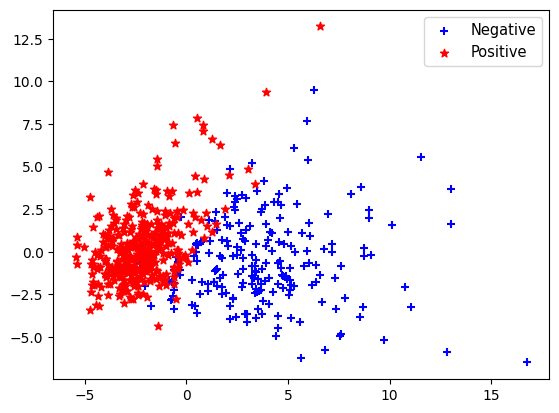

In [4]:
pca = PCA(n_components=2)
x_scaled = preprocessing.scale(x[:,:-1]) # We remove the indexing and make sure all the features are in N(0,1)
x_reduced = pca.fit_transform(x_scaled)
# x_reduced = pca.fit_transform(x[:,0:-1]) # Uncomment this to see the result without scaling

plt.scatter(x_reduced[:,0][y==0], x_reduced[:,1][y==0], c='b', marker="+", label="Negative")
plt.scatter(x_reduced[:,0][y==1], x_reduced[:,1][y==1], c='r', marker="*", label="Positive")
plt.legend(loc="upper right", fontsize=10.5)
plt.show()

# Caluculation of Entropy

y is a vector of length n, where n represents the total number of data points. Each element in the vector represents the class or category of the corresponding data point and is represented as an integer. Specifically, the first class is denoted by 0, and the second class is denoted by 1.

In [5]:
n0, n1 = np.unique(y, return_counts= True)[1]

# Entropy function
def calculate_entropy(y):
    n = len(y)
    if 0 not in y and 1not in y: #y=[]
        p0=p1=0
    else:
        n=len(y)
        if 0 in y and 1in y: #y=[0,1]
            n0,n1= np.unique(y, return_counts= True)[1]
        elif 0 in y and 1not in y:#y=[1]
            n0 = np.unique(y, return_counts= True)[1]
            n1 = 0
        else: #y=[0]
            n0 = 0
            n1 = np.unique(y, return_counts= True)[1]
        p0 = n0/n
        p1 = n1/n 
    
    if p0 ==0:
        return 0
    elif p1==0:
        return 0
    else:
        entropy = -p0.astype(float)*np.log2(p0.astype(float))-p1.astype(float)*np.log2(p1.astype(float))
        
    return entropy

y = data_all.target
print("The entropy of 'y' is: {:.4f}".format(calculate_entropy(y)))

The entropy of 'y' is: 0.9526


# Find the best splits

In [6]:
def find_split(x, y):
    """Given a dataset and its target values, this finds the optimal combination
    of feature and split point that gives the maximum information gain."""
    
    # The starting entropy
    start_entropy = calculate_entropy(y)
    
    # Initialisation
    best = {'infogain' : -np.inf}

    # Loop every possible split of every dimension...
    for i in range(x.shape[1]):
        for split in np.unique(x[:,i]):

            left_indices = np.nonzero(x[:,i]<=split)[0]
            right_indices = np.nonzero(x[:,i]>split)[0]
            left_child = y[left_indices]
            right_child = y[right_indices]
            split_entoropy = calculate_entropy(left_child)*(len(left_child)/len(y))+calculate_entropy(right_child)*(len(right_child)/len(y))
            infogain = start_entropy - split_entoropy
            
            if infogain > best['infogain']:
                best = {'feature' : i,
                        'split' : split,
                        'infogain' : infogain, 
                        'left_indices' : left_indices,
                        'right_indices' : right_indices}
        
    return best

# Build Tree

In [7]:
def build_tree(x, y, max_depth = np.inf):
    # Check if either of the stopping conditions have been reached. If so generate a leaf node...
    if max_depth==1 or (y==y[0]).all():
        # Generate a leaf node
        classes, counts = np.unique(y, return_counts=True)
        return {'leaf' : True, 'class' : classes[np.argmax(counts)]} #classes select lager one between 0,1
    
    else:
        move = find_split(x, y)
        
        left = build_tree(x[move['left_indices'],:], y[move['left_indices']], max_depth - 1)
        right = build_tree(x[move['right_indices'],:], y[move['right_indices']], max_depth - 1)
        
        return {'leaf' : False,
                'feature' : move['feature'],
                'split' : move['split'],
                'infogain' : move['infogain'],
                'left' : left,
                'right' : right}

# Prediction

In [8]:
def predict(tree, samples):
    """Predicts class for every entry of a data matrix."""
    ret = np.empty(samples.shape[0], dtype=int)
    ret.fill(-1)
    indices = np.arange(samples.shape[0])
    
    def tranverse(node, indices):
        nonlocal samples
        nonlocal ret
        
        if node['leaf']:
            ret[indices] = node['class']
        
        else:
            going_left = samples[indices, node['feature']] <= node['split']
            left_indices = indices[going_left]
            right_indices = indices[np.logical_not(going_left)]
            
            if left_indices.shape[0] > 0:
                tranverse(node['left'], left_indices)
                
            if right_indices.shape[0] > 0:
                tranverse(node['right'], right_indices)
    
    tranverse(tree, indices)
    return ret

# Accuracy

In [9]:
def evaluate(x_train, y_train, x_test, y_test, max_depth):
    
    train_tree = build_tree(x_train, y_train, max_depth)
    predict(train_tree, x_train)
    train_acc =1- sum(np.abs(predict(train_tree, x_train)-y_train))/len(y_train)
    test_acc =1- sum(np.abs(predict(train_tree, x_test)-y_test))/len(y_test)
    return train_acc, test_acc


train_acc, test_acc = evaluate(x_train, y_train, x_test, y_test, np.inf)
print('Train Accuracy: {:.2f}%'.format(train_acc*100))
print('Test Accuracy: {:.2f}%'.format(test_acc*100))

Train Accuracy: 100.00%
Test Accuracy: 89.91%


# Optimization for tree depth

In [10]:
def find_best_max_depth(x_train, y_train, x_test, y_test):
    best_max_depth = -1
    best_train_acc = -1
    best_test_acc = -1
    for depth in range(2,6):
        train_acc, test_acc = evaluate(x_train, y_train, x_test, y_test, depth)
        if test_acc >=best_test_acc:
            best_test_acc = test_acc
            best_train_acc = train_acc
            best_max_depth = depth
    return best_max_depth, best_train_acc, best_test_acc


best_max_depth, best_train_acc, best_test_acc = find_best_max_depth(x_train, y_train, x_test, y_test)
print('The best max_depth is {}, and the corresponding training and test accuracies are {:.2f}% and {:.2f}% respectively.'.format(best_max_depth,best_train_acc*100,best_test_acc*100))

The best max_depth is 4, and the corresponding training and test accuracies are 97.36% and 91.67% respectively.
